In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import process_data.dire_and_coor as dc
import functions as func
import process_data.n_n_distance as nn
import json
from tqdm.auto import tqdm

## Nov 5
### random polymer for 4 layers

In [2]:
def check_output_hist(output, epoch):

    output = output.reshape(-1,1)

    sns.histplot(output)
    plt.title(f'output of generator{epoch}')
    plt.show()

    output = np.round(output)
    sns.histplot(output)
    plt.title('output of generator after round')
    plt.show()


# def round_and_reshape(model, num_polymer, z_dim):
#     # load model
#     # get output
#     # noise = func.get_noise(num_polymer, z_dim)
#     # output = model(noise).data.numpy()
#     # round and reshape output
#     output = np.round(output * 4) / 4
#     if shifted:
#         output += (0.75/2)
#     for i in range(len(output)):
#         for j in range(len(output[i])):
#             if output[i][j] == 1.:
#                 output[i][j] = 0
#     directions_14 = output.reshape((num_polymer, 14, 1))
#     directions = np.zeros((num_polymer, 15, 1))
#     for i in range(len(directions)):
#         directions[i] = np.vstack(([0], directions_14[i]))
#     return directions

def directions_to_str(directions):
    st_all = []
    for direction in directions:
        st = ""
        for i in direction:
            st += str(int(i[0] * 4))
        st_all.append(st)
    return st_all

def convert_sin_cos_to_directions(output):
    output = output.reshape(num_polymer, 14, 2)
    # convert sin cos coordinates to turn directions
    directions = np.zeros([num_polymer, 14, 1])
    convert = {
        "backward": 0,
        "right_turn": 1/4,
        "forward": 1 / 2,
        "left_turn": 3 / 4
    }

    for index, direction in enumerate(directions):
    # test = np.zeros((14, 1))
    #     j = 0
        for j, item in enumerate(output[index]):
            if item[np.argmax(np.abs(item))] < 0:
                if np.argmax(np.abs(item)) == 0:
                    # the result is [-1,0]
                    direction[j] = convert['backward']
                else:
                    # result is [0,-1]
                    direction[j] = convert['left_turn']
            elif item[np.argmax(np.abs(item))] > 0:
                if np.argmax(np.abs(item)) == 0:
                    # the result is [1,0]
                    direction[j] = convert['forward']
                else:
                    # result is [0,1]
                    direction[j] = convert['right_turn']
    return directions

def check_fold_cross(coordinate):
    """
    check if a single polymer is folding or crossing
    """
    assert np.shape(coordinate) == (16, 2)
    folding_count = 0
    crossing_count = 0
    for i in range(0, len(coordinate)):
        temp = coordinate[i]
        if (temp == coordinate[:i]).all(axis=1).any():
            if np.array_equal(temp, coordinate[:i][-2]):
                folding_count += 1
            else:
                crossing_count += 1
    return [folding_count, crossing_count]

<AxesSubplot:ylabel='Count'>

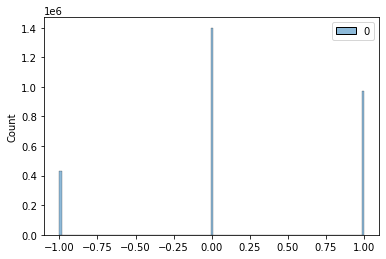

In [3]:
input_directions = np.load('../data/self_avoid/16/directions.npy')
input_sin_cos = np.load('../data/self_avoid/16/sin_cos.npy')
input_coordinates = np.load('../data/self_avoid/16/coorinates.npy')
input_hist = input_sin_cos.reshape(-1, 1)
sns.histplot(input_hist)

## conclusion we can draw for now
1. the single node won't work for GAN, single node means no hidden layers, no matter how many

GeneratorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=14, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=64, out_features=28, bias=True)
    (1): Tanh()
  )
)


  0%|          | 0/20 [00:00<?, ?it/s]

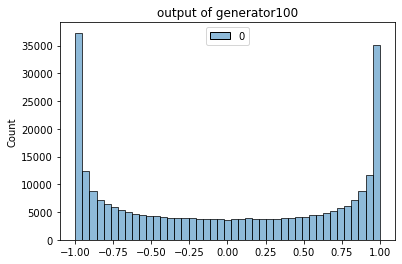

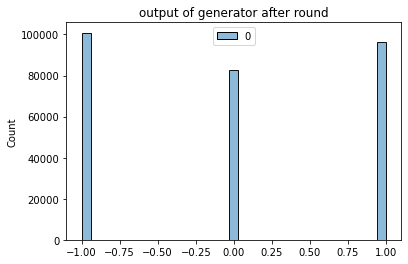

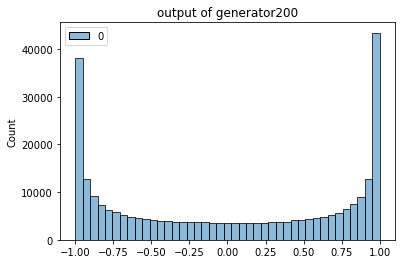

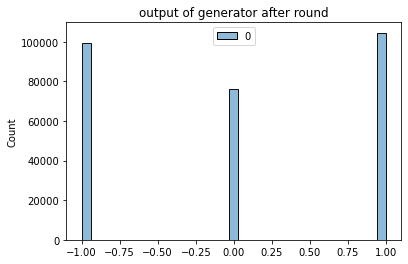

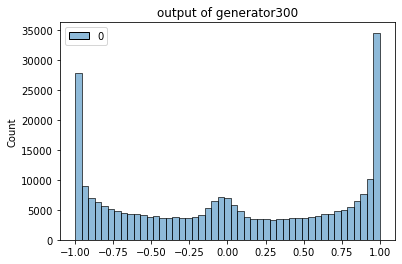

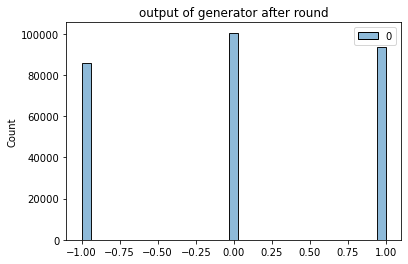

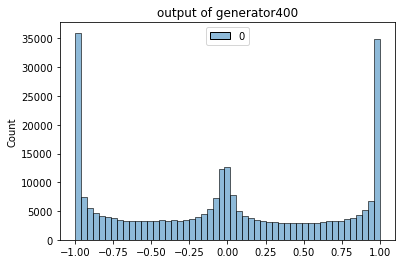

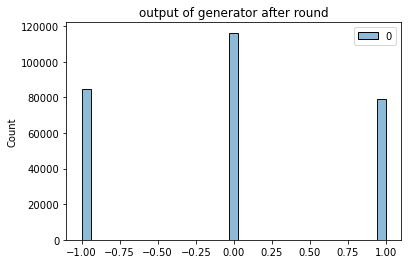

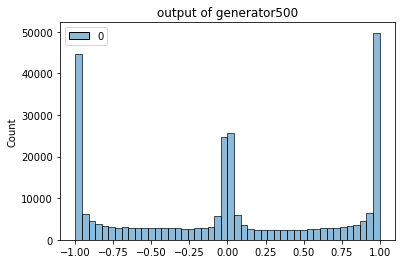

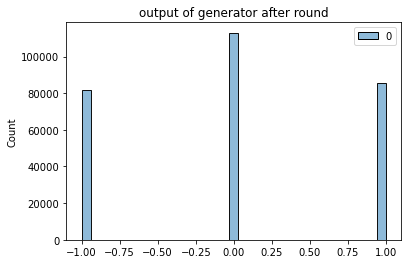

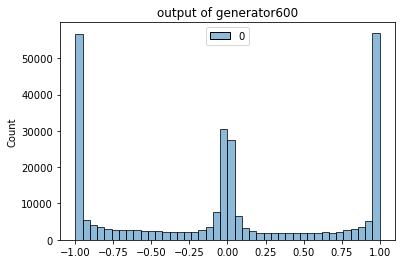

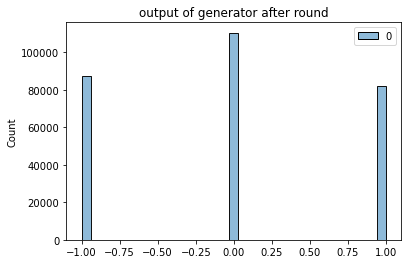

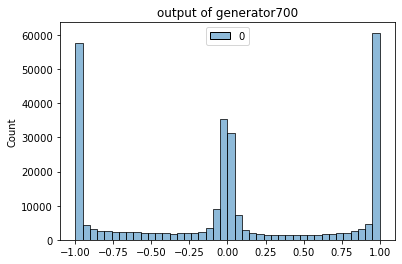

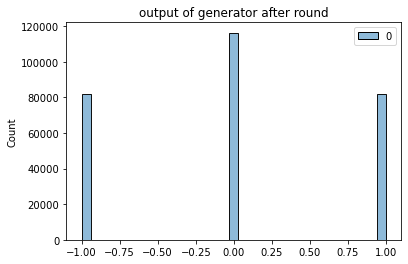

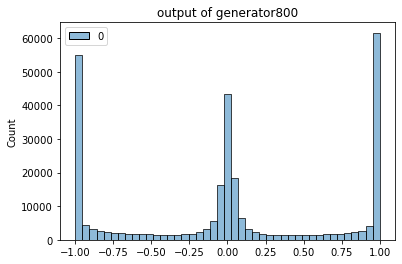

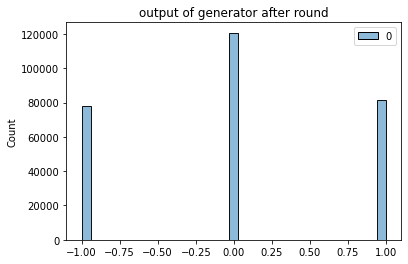

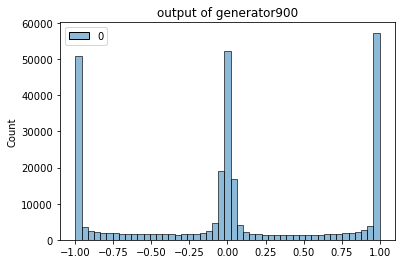

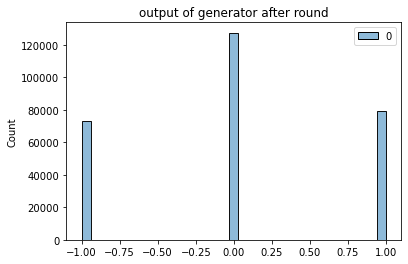

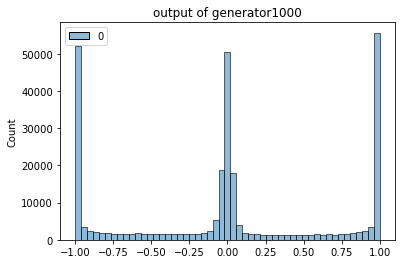

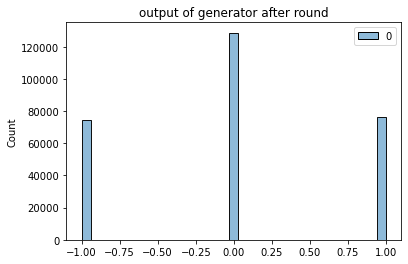

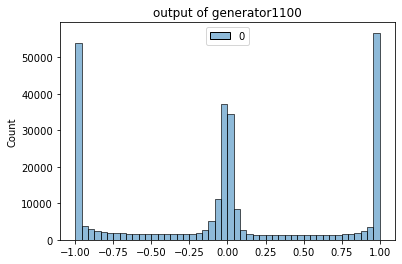

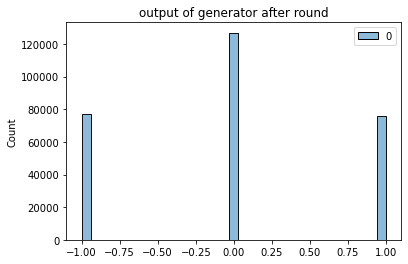

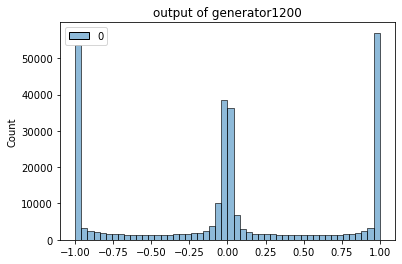

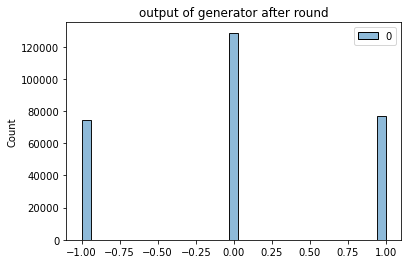

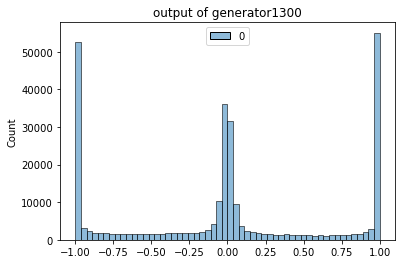

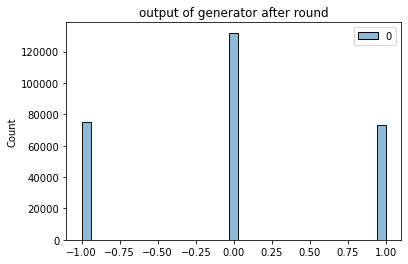

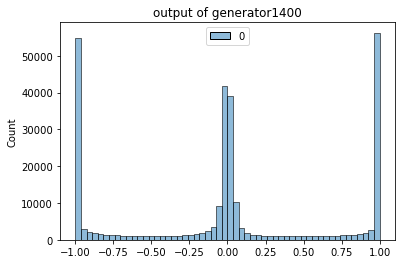

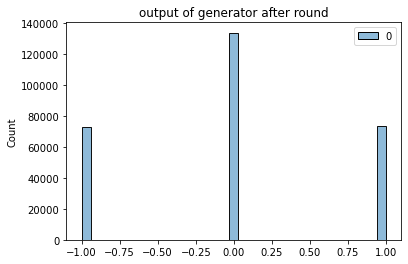

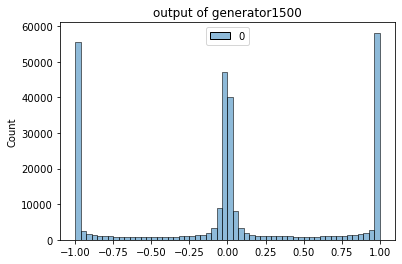

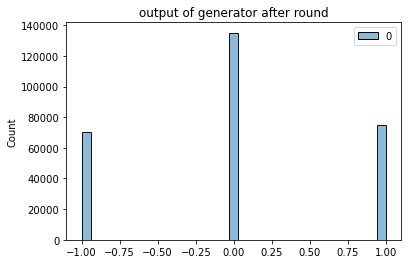

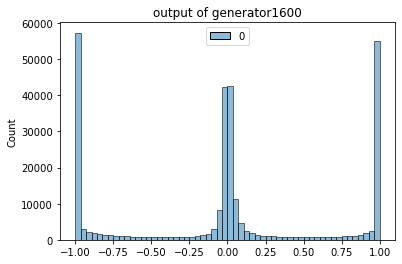

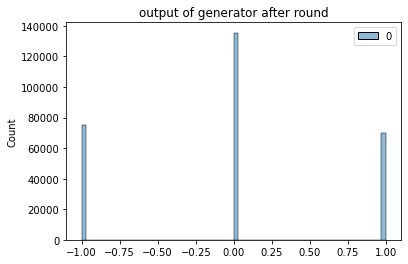

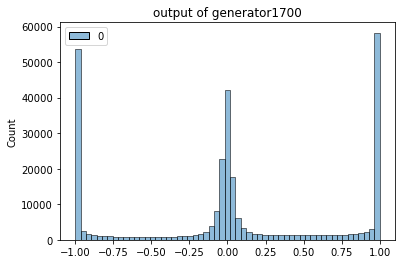

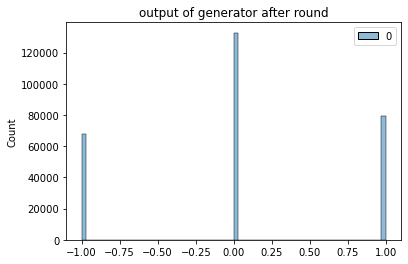

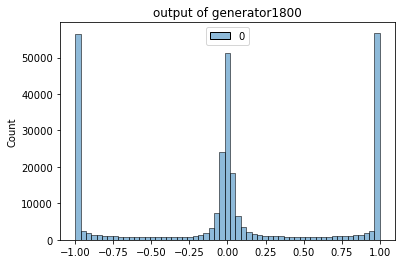

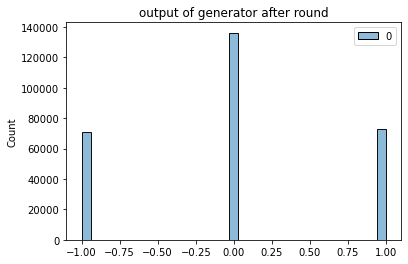

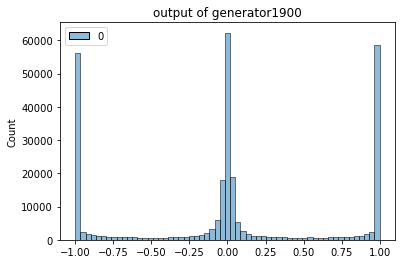

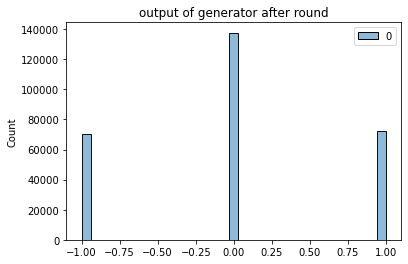

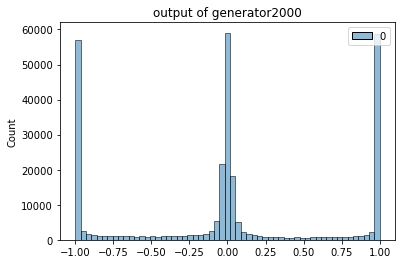

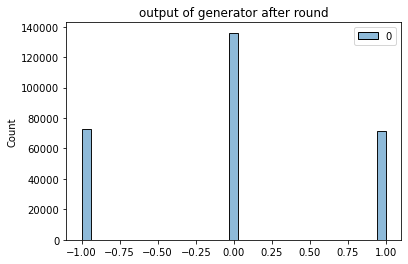

In [45]:
import fnn.four_layers as model
z_dim = 14
generator = model.GeneratorNet(z_dim, 28)
print(generator)
num_polymer = 10000
noise = func.get_noise(num_polymer, z_dim)
nn_distance = []
self_avoid_count = []
total_epochs = 2100
for i in tqdm(range(100, total_epochs, 100)):
    check_point = torch.load(f'../experiments/11_5/four_layers_sin_cos_gen_{i}.pth.tar')
    generator.load_state_dict(check_point['gen_state_dict'])
    output = generator(noise).data.numpy()
    check_output_hist(output, i)
    fake_directions = convert_sin_cos_to_directions(output)
    a = np.zeros((10000, 15, 1))
    # make the first one is forward
    for i in range(len(a)):
        a[i] = np.vstack(([0], fake_directions[i]))
    coordinates = dc.direction_coordinate_three(a, 16)
    nn_distance.append(nn.n_n_distance(coordinates))

    # check the number of self avoid polymers
    # check_list = []
    # for coordinate in coordinates:
    #     check_list.append(check_fold_cross(coordinate))
    # count = 1
    # for i in check_list:
    #     if i == [0,0]:
    #         count += 1
    # self_avoid_count.append(count)

[3.0168858115613193, 5.307956292208895, 3.521306575690336, 3.503426893771297, 3.956159754104983, 3.732827346663652, 3.842915559832144, 3.323732841249429, 2.9629039808944198, 4.415789850072125]


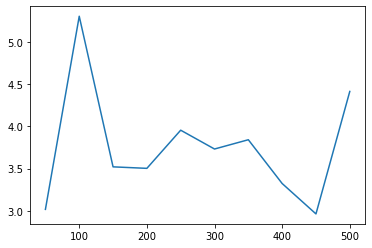

In [42]:
epoch = [i for i in range(50, total_epochs, 50)]
# print(self_avoid_count)
print(nn_distance)
# plt.plot(epoch, self_avoid_count)
plt.show()
plt.plot(epoch, nn_distance)


In [43]:
# check overlap
overlap = 0
input_st = directions_to_str(input_directions)
fake_st = directions_to_str(fake_directions)
for i in fake_st:
    if i in input_st:
        overlap += 1
print(overlap)

KeyboardInterrupt: 

In [13]:
def read_json(file_path):
    """
    :param file_path: the path of json file
    :return: a python dict
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    return data

In [14]:
gen_data = read_json('../experiments/11_7/five_layers_sin_cos_gen.json')
disc_data = read_json('../experiments/11_7/five_layers_sin_cos_disc.json')

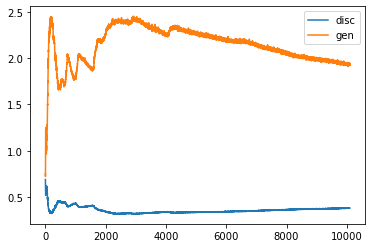

In [15]:
gen_loss = []
disc_loss = []
for i in gen_data:
    gen_loss += gen_data[i]
    disc_loss += disc_data[i]

plt.plot(disc_loss, label='disc')
plt.plot(gen_loss, label='gen')
plt.legend()
plt.show()

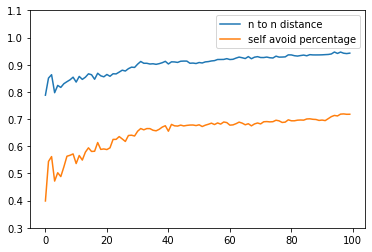

In [40]:
a = np.array(nn_distance)
a = a / 6.99
# a = a / np.sqrt(15)
b = np.array(self_avoid_count)
b = b / 10000
plt.plot(a, label='n to n distance')
plt.ylim(0.3,1.1)
plt.plot(b, label = 'self avoid percentage')
plt.legend()

In [23]:
ls = list(set(fake_st))
print(f'the percentage of unique is {len(ls) / 10000 }')

the percentage of unique is 0.9645
